**Problem Statement**
Implement the paper : Skin Dieseae Detection using Deep Learning.

**Dataset**
Using Dataset provided from Kaggle

**PR Group 4**
Ravi Kant Singh 2K22AFI30
Vershika Srivastava 2K22AFI28


In [ ]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential, regularizers, metrics

from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

!pip install scikit-plot
from scikitplot.metrics import plot_roc

!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score, MatthewsCorrelationCoefficient

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining a class for various Constants used in the project code.

In [ ]:
class CFG:
  EPOCHS=25
  BATCH_SIZE=32
  SEED=131
  TF_SEED=1034
  HEIGHT=224
  WIDTH=224
  CHANNELS=3
  IMAGE_SIZE=(224,224,3)


In [ ]:
DATASET_PATH='/content/drive/MyDrive/skin_dataset_resized'
TRAIN_PATH='/content/drive/MyDrive/skin_dataset_resized/train_set'
TEST_PATH='/content/drive/MyDrive/skin_dataset_resized/test_set'
VAL_PATH='/content/drive/MyDrive/skin_dataset_resized/val_set'


In [ ]:
print('DATASET SUMMARY')
print('================\n')
for dirpath,dirnames,filenames in os.walk(DATASET_PATH):
  print("There are ",len(dirnames)," directories", "and ",len(filenames), "images in ",dirpath)
print('\n=============')

DATASET SUMMARY

There are  3  directories and  0 images in  /content/drive/MyDrive/skin_dataset_resized
There are  2  directories and  0 images in  /content/drive/MyDrive/skin_dataset_resized/train_set
There are  0  directories and  4001 images in  /content/drive/MyDrive/skin_dataset_resized/train_set/malignant
There are  0  directories and  5200 images in  /content/drive/MyDrive/skin_dataset_resized/train_set/benign
There are  2  directories and  0 images in  /content/drive/MyDrive/skin_dataset_resized/val_set
There are  0  directories and  550 images in  /content/drive/MyDrive/skin_dataset_resized/val_set/malignant
There are  0  directories and  550 images in  /content/drive/MyDrive/skin_dataset_resized/val_set/benign
There are  2  directories and  0 images in  /content/drive/MyDrive/skin_dataset_resized/test_set
There are  0  directories and  550 images in  /content/drive/MyDrive/skin_dataset_resized/test_set/benign
There are  0  directories and  550 images in  /content/drive/MyDri

Loading Images from the folders

In [ ]:
%%time
train_images=glob.glob(TRAIN_PATH+'/**/*.jpg',recursive=True)
test_images =glob.glob(TEST_PATH+'/**/*.jpg',recursive=True)
val_images=glob.glob(VAL_PATH+'/**/*.jpg',recursive=True)


CPU times: user 59.4 ms, sys: 4.65 ms, total: 64 ms
Wall time: 683 ms


In [ ]:
train_size=len(train_images)
test_size=len(test_images)

total=train_size + test_size

print(f"train samples count:\t\t {train_size}")
print('test samples count:\t\t',test_size)
print('==============================')
print('Total : \t\t\t',total)


train samples count:		 9201
test samples count:		 1100
Total : 			 10301


create Panda Dataframe for paths and labels

In [ ]:
def generate_labels(image_paths):
  return [_.split('/')[-2:][0] for _ in image_paths]

def build_df(image_paths,labels):
  df=pd.DataFrame({'image_path': image_paths, 'label':generate_labels(labels)})

  df['label_encoded'] = df.apply(lambda row:0 if row.label =='malignant' else 1, axis=1)

  return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)



Creating Pandas Dataframe for Train, test, val images and labels

In [ ]:
train_df=build_df(train_images,generate_labels(train_images))
test_df=build_df(test_images,generate_labels(test_images))
val_df=build_df(val_images,generate_labels(val_images))

In [ ]:
train_df.head()

image_path      label  label_encoded
0  /content/drive/MyDrive/skin_dataset_resized/tr...  malignant              0
1  /content/drive/MyDrive/skin_dataset_resized/tr...     benign              1
2  /content/drive/MyDrive/skin_dataset_resized/tr...  malignant              0
3  /content/drive/MyDrive/skin_dataset_resized/tr...     benign              1
4  /content/drive/MyDrive/skin_dataset_resized/tr...  malignant              0

In [ ]:
test_df.head()

image_path      label  label_encoded
0  /content/drive/MyDrive/skin_dataset_resized/te...     benign              1
1  /content/drive/MyDrive/skin_dataset_resized/te...  malignant              0
2  /content/drive/MyDrive/skin_dataset_resized/te...     benign              1
3  /content/drive/MyDrive/skin_dataset_resized/te...  malignant              0
4  /content/drive/MyDrive/skin_dataset_resized/te...  malignant              0

Helper Function to load and visualise images.

In [ ]:
def _load(image_path):
  #reading and decoding image file to unit8 tensor
  image=tf.io.read_file(image_path)
  image=tf.io.decode_jpeg(image,channels=3)

  #resizing images
  image=tf.image.resize(image,[CFG.HEIGHT,CFG.WIDTH],method=tf.image.ResizeMethod.LANCZOS3)

  #covert image dtype to float32 and normalize
  image=tf.cast(image,tf.float32)/255
  return image

In [ ]:
def view_sample(image,label, color_map='rgb', fig_size=(8,10)):
  plt.figure(figsize=fig_size)

  if color_map=='rgb':
    plt.imshow(image)
  else:
    plt.imshow(tf.image.rgb_to_grayscale(image),cmap=color_map)

  plt.title(f'Label: {label}', fontsize=16)
  return

In [ ]:
#select random sample from train_df
idx=random.sample(train_df.index.to_list(),1)[0]

sample_image,sample_label=_load(train_df.image_path[idx]),train_df.label[idx]
#view the random sample
view_sample(sample_image,sample_label,color_map='inferno')



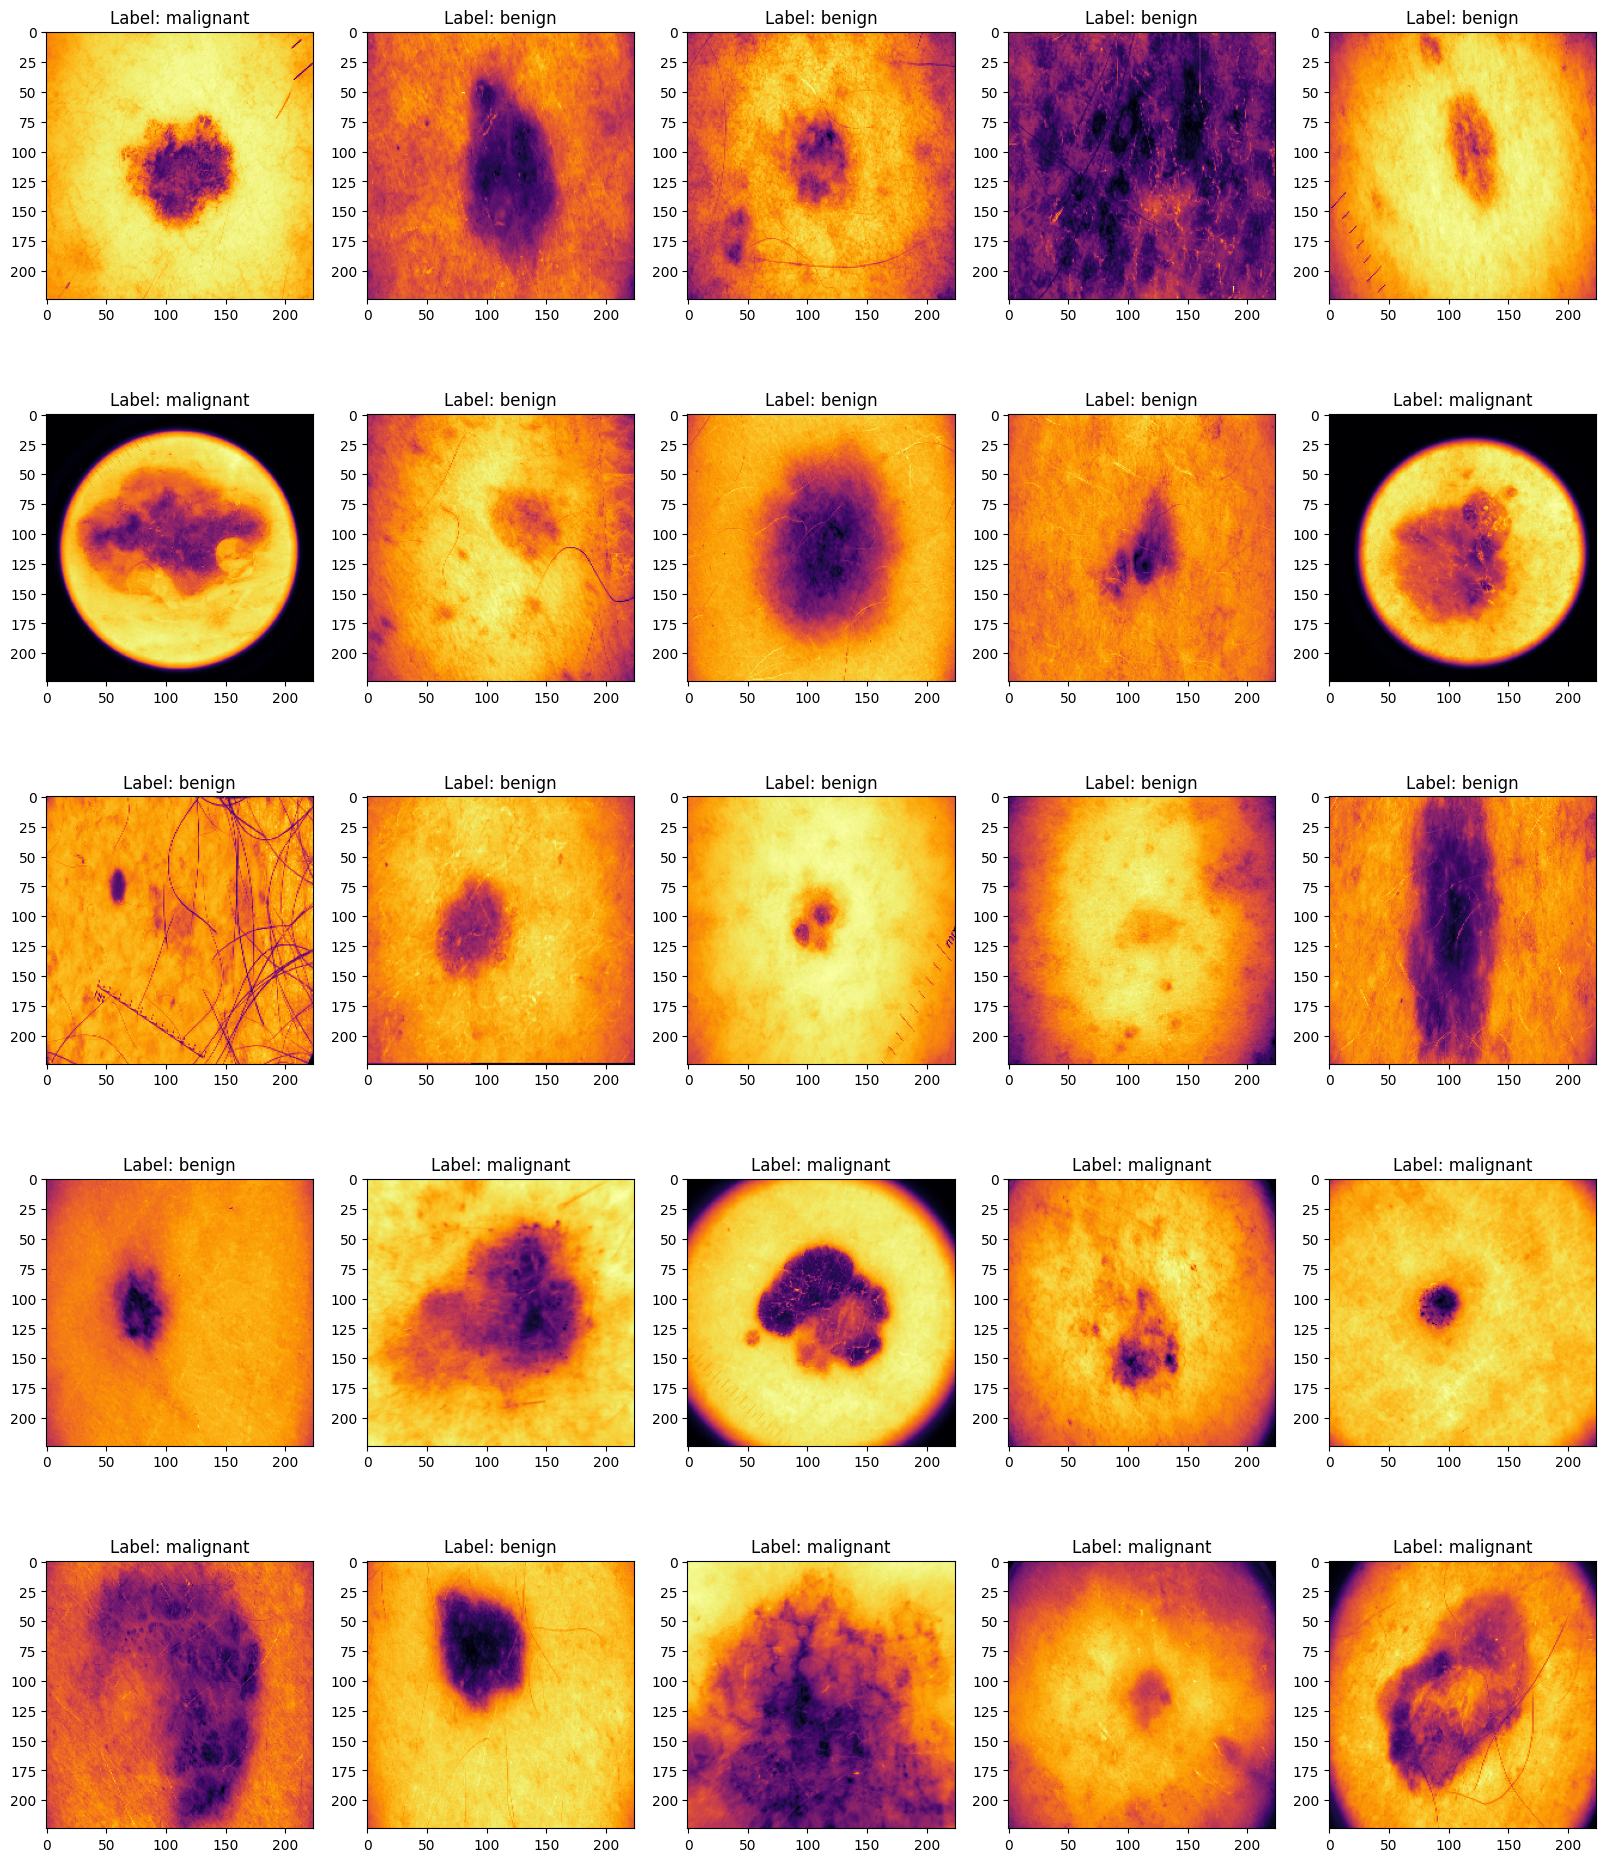

In [ ]:
def view_multiple_samples(df,sample_loader,count=10,color_map='rgb', fig_size=(14,10)):
  rows=count//5
  if count%5>0:
    rows+=1

  idx=random.sample(df.index.to_list(),count)
  fig=plt.figure(figsize=fig_size)

  for column, _ in enumerate(idx):
    plt.subplot(rows,5,column+1)
    plt.title(f'Label: {df.label[_]}')
    if color_map=='rgb':
      plt.imshow(sample_loader(df.image_path[_]))
    else:
      plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])),cmap=color_map)

  return

view_multiple_samples(train_df, _load, count=25, color_map='inferno',fig_size=(20,24))



View Train Labels Distribution

<Axes: title={'center': 'Test Labels Distribution'}>

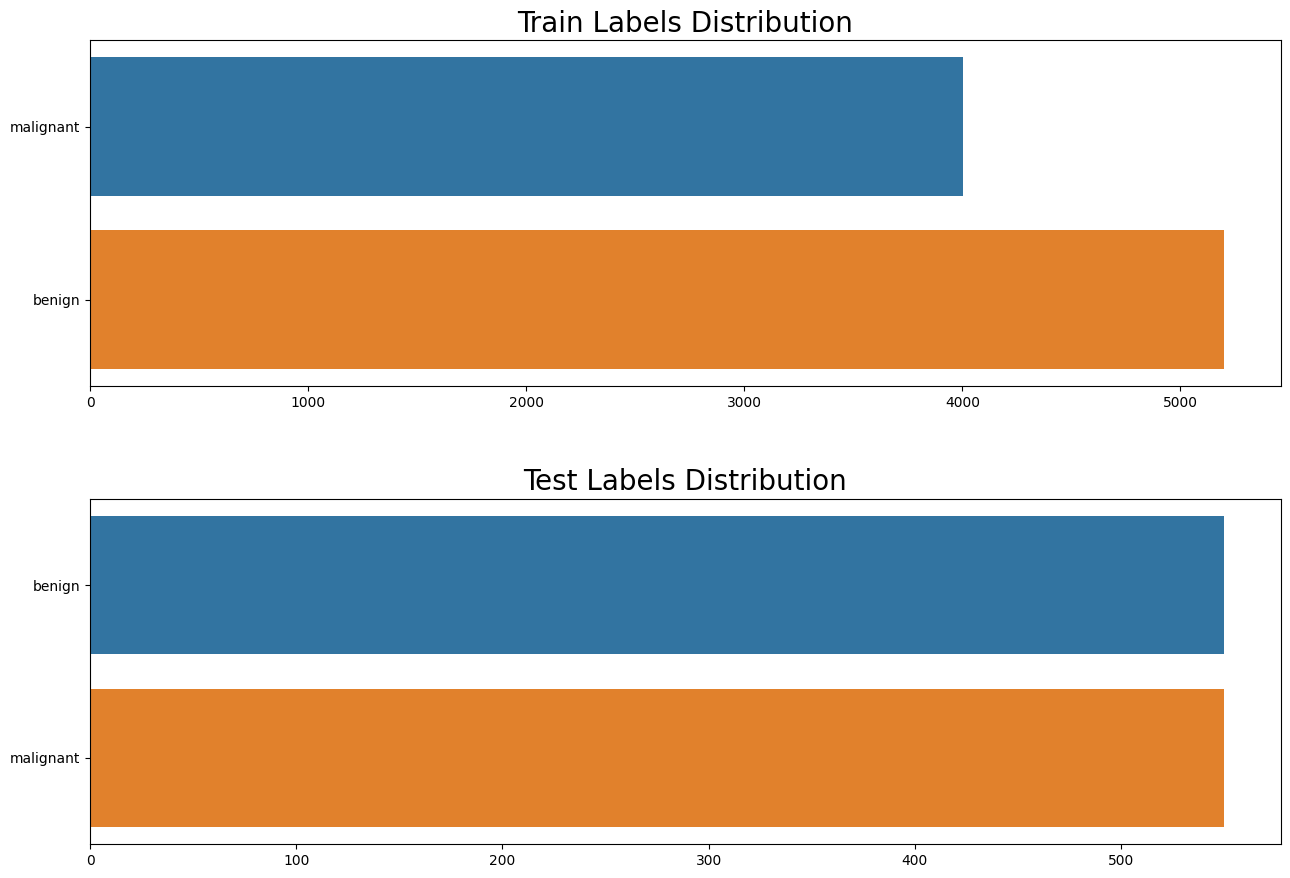

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(14,10))

fig.tight_layout(pad=6.0)

ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient='h',
            ax=ax1)

ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient='h',
            ax=ax2)

### Balancing Benign and Malign Data in Train Set

In [ ]:
benign_idx=train_df[train_df['label']=='benign'].index
malignant_idx=train_df[train_df['label']=='malignant'].index
new_train_df=train_df[train_df['label']=='benign'].sample(n=len(malignant_idx))
malignant_train_df=train_df[train_df['label']=='malignant']

new_train_df=pd.concat([new_train_df,malignant_train_df])
new_train_df['label'].value_counts()


benign       4001
malignant    4001
Name: label, dtype: int64

<Axes: title={'center': 'Test Labels Distribution'}>

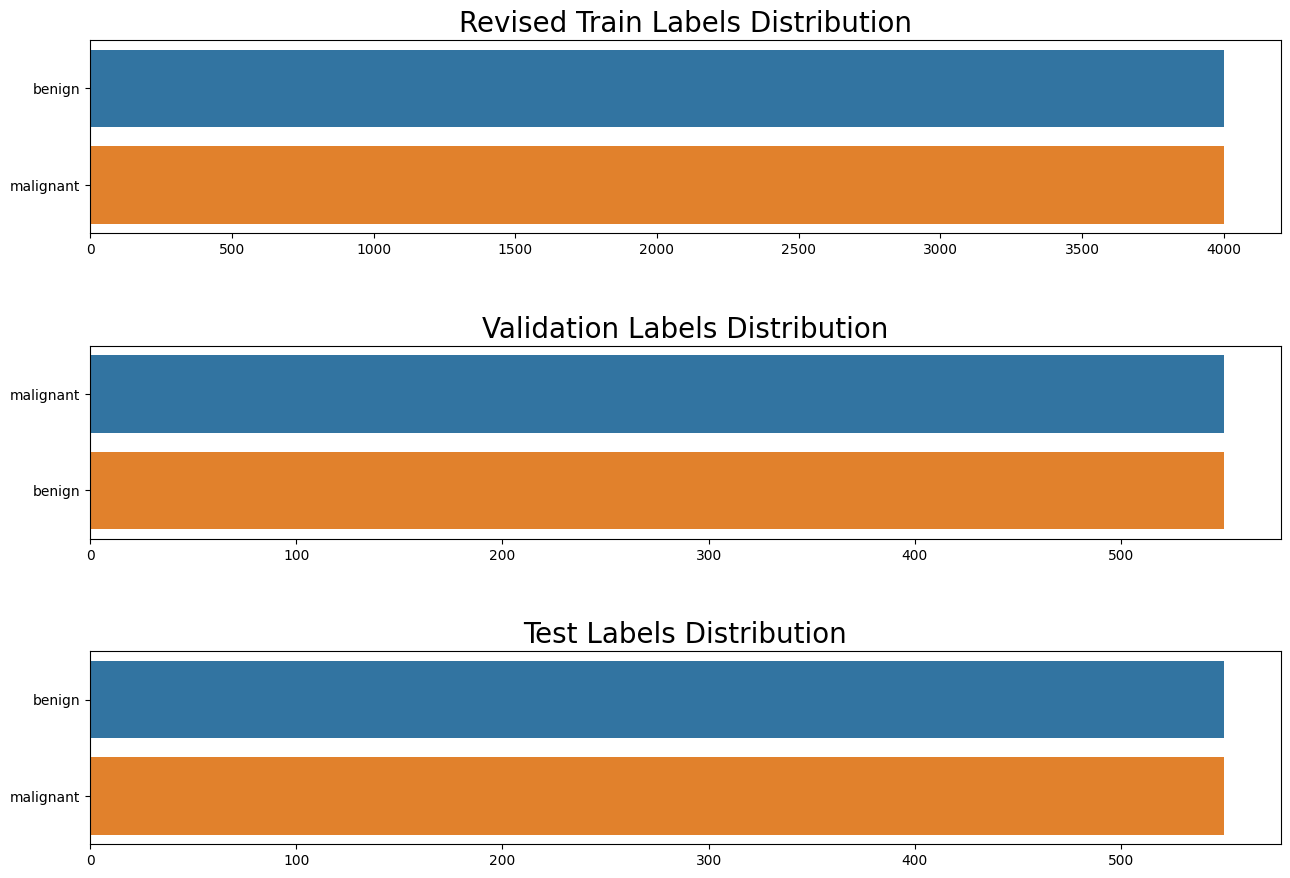

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(14,10))

fig.tight_layout(pad=6.0)

ax1.set_title('Revised Train Labels Distribution', fontsize=20)
train_distribution = new_train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient='h',
            ax=ax1)
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient='h',
            ax=ax2)

ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient='h',
            ax=ax3)

In [ ]:
train_df=new_train_df.sample(frac=1)

Implementing Preprocessing. Building an input data Pipeline


In [ ]:
train_df.shape,test_df.shape,val_df.shape

((8002, 3), (1100, 3), (1100, 3))

**Data Augmentation for Trainset**
Create an Image Data Augmentation Layer


In [ ]:
#Build Augmentation layer
augmentation_layer=Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical',seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),seed=CFG.TF_SEED)],
    name='augmentation_layer'
)

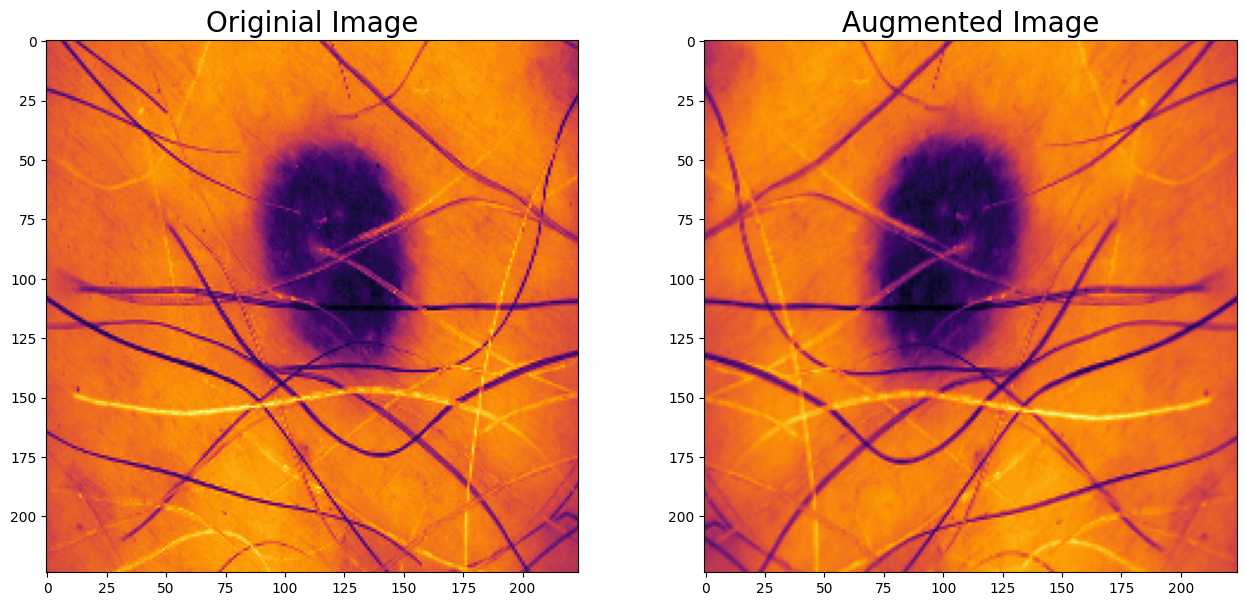

In [ ]:
image=tf.image.rgb_to_grayscale(sample_image)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,10))

#set the spacing between subplots
fig.tight_layout(pad=6.0)
#view orignial Image
ax1.set_title('Originial Image',fontsize=20)
ax1.imshow(image,cmap='inferno')
#view augmented image
ax2.set_title('Augmented Image',fontsize=20)
ax2.imshow(augmentation_layer(image),cmap='inferno')

Load Images in numpy array from dataframes

In [ ]:
def encode_labels(labels,encode_depth=2):
  return tf.one_hot(labels,depth=encode_depth).numpy()

def create_pipeline(df,load_function,augment=False,batch_size=32,shuffle=False,cache=None,prefetch=False):

  # Get image paths and labels from DatFrame
  image_paths = df.image_path
  image_labels= encode_labels(df.label_encoded)
  AUTOTUNE=tf.data.AUTOTUNE

  #create dataset with raw data from DataFrame
  ds= tf.data.Dataset.from_tensor_slices((image_paths,image_labels))

  #map augmentation layer and load fucnction to dataset input if augment is true
  if augment:
    ds=ds.map(lambda x,y :(augmentation_layer(load_function(x)),y),num_parallel_calls=AUTOTUNE)
  else:
    ds=ds.map(lambda x,y:(load_function(x),y),num_parallel_calls=AUTOTUNE)

  #applying shuffle
  if shuffle:
    ds=ds.shuffle(buffer_size=1000)

  #apply batching
  ds=ds.batch(batch_size)

  #apply caching based on condition
  #Note: use cache in memory(cache='') if the data is small enough to fit in memory
  if cache !=None:
    ds=ds.cache(cache)

  if prefetch:
    ds=ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
#Generate Train Input Pipeline
train_ds=create_pipeline(train_df,_load,augment=True,batch_size=CFG.BATCH_SIZE,
                          shuffle=False,
                          prefetch=True)
val_ds=create_pipeline(val_df,_load, augment=False,batch_size=CFG.BATCH_SIZE,
                       shuffle=False,
                       prefetch=False)
test_ds=create_pipeline(test_df,_load,
                        batch_size=CFG.BATCH_SIZE,
                        shuffle=False,
                        prefetch=False)

# Downloading ResNet50V2 Model
Pretrained model over 'Imagenet'

In [ ]:
resnet=ResNet50V2(input_shape=CFG.IMAGE_SIZE, weights='imagenet',include_top=False)

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
#Training Every layer of ResNet50 Model
for layer in resnet.layers:
  layer.trainable=True


In [ ]:
#defining model
model_name='ResNet50_local'
tf.random.set_seed(CFG.SEED)
def resnet_model():
  initializer=tf.keras.initializers.GlorotNormal()

  resnet_sequential=Sequential([
      layers.Input(shape=CFG.IMAGE_SIZE,dtype=tf.float32,name='input_image'),
      #using ResNet
      resnet,
      #applying 64 convolution of 3x3 kernel
      layers.Conv2D(64,(3,3),padding='same',activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      Flatten(),
      #creating a dense layer of 256 units
      layers.Dense(256,activation='relu',kernel_initializer=initializer,
                   kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4),
                   activity_regularizer=regularizers.L2(1e-5)),
      layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(alpha=0.08),
      layers.Dropout(0.5),
      layers.Dense(2,dtype=tf.float32,activation='sigmoid',kernel_initializer=initializer)],
      name='ResNet50_Sequential'
  )
  return resnet_sequential


In [ ]:
#generating model
model_resnet_local=resnet_model()
model_resnet_local.summary()

Model: "ResNet50_Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          1179712   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 flatten (Flatten)           (None, 576)       

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


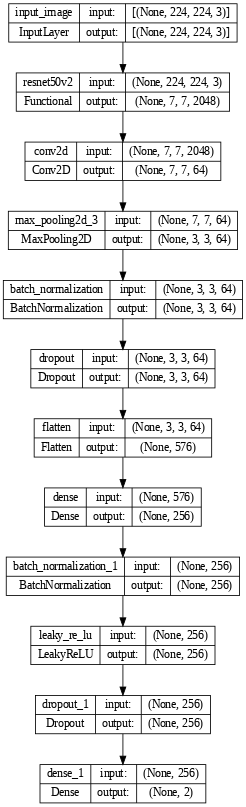

In [ ]:
plot_model(model_resnet_local,dpi=60,show_shapes=True)

In [ ]:
#Trainging Model a function to carryout training of model and carrying out Validation model
def train_model(model,num_epochs,callbacks_list,tf_train_data,tf_valid_data=None,shuffling=False):
  model_histroy={}
  if tf_valid_data !=None:
    model_history=model.fit(tf_train_data,
                            epochs=num_epochs,
                            validation_data=tf_valid_data,
                            validation_steps=int(len(tf_valid_data)),
                            callbacks=callbacks_list,
                            shuffle=shuffling)
  if tf_valid_data==None:
    model_history=model.fit(tf_train_data,
                            epochs=num_epochs,
                            validation_data=tf_valid_data,
                            callbacks=callbacks_list,
                            shuffle=shuffling)
  return model_history

In [ ]:

#defining early stopping

early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
#defining reduce learning rate callback
reduce_lr_callback=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.1,
    verbose=1
)

#define callbacks and metrics
#CALLBACKS=[early_stopping_callback,reduce_lr_callback]
CALLBACKS=[reduce_lr_callback]
METRICS=['accuracy',
         metrics.Precision(name='precision'),
         metrics.Recall(name='recall'),
         F1Score(num_classes=2,name='f1'),
         MatthewsCorrelationCoefficient(num_classes=2,name='mc'),
         tf.keras.metrics.TruePositives(name='tp'),
         tf.keras.metrics.TrueNegatives(name='tn'),
         tf.keras.metrics.FalseNegatives(name='fn'),
         tf.keras.metrics.FalsePositives(name='fp')]

In [ ]:
model_path='/content/drive/MyDrive/Colab Notebooks/my_model.h5'
v_model=tf.keras.models.load_model(model_path)

#Training the Model

In [ ]:
tf.random.set_seed(CFG.SEED)

model_resnet_local.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model_resnet_local.name}')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('-----------------------------------')

model_resnet_local_history=train_model(model_resnet_local,
                                       CFG.EPOCHS,
                                       CALLBACKS,
                                       train_ds,
                                       val_ds,
                                       shuffling=False)


Training ResNet50_Sequential
Train on 8002 samples, validate on 1100 samples.
-----------------------------------
Epoch 1/25
251/251 [==============================] - 1115s 4s/step - loss: 0.5028 - accuracy: 0.8439 - precision: 0.8312 - recall: 0.8329 - f1: 0.8401 - mc: 0.6834 - tp: 7011.0000 - tn: 6994.0000 - fn: 1407.0000 - fp: 1424.0000 - val_loss: 58.1368 - val_accuracy: 0.7000 - val_precision: 0.7054 - val_recall: 0.6573 - val_f1: 0.6945 - val_mc: 0.4092 - val_tp: 723.0000 - val_tn: 798.0000 - val_fn: 377.0000 - val_fp: 302.0000 - lr: 0.0010
Epoch 2/25
251/251 [==============================] - 142s 567ms/step - loss: 0.4123 - accuracy: 0.8765 - precision: 0.8758 - recall: 0.8753 - f1: 0.8763 - mc: 0.7560 - tp: 7004.0000 - tn: 7009.0000 - fn: 998.0000 - fp: 993.0000 - val_loss: 0.8056 - val_accuracy: 0.5418 - val_precision: 0.5407 - val_recall: 0.5373 - val_f1: 0.4237 - val_mc: 0.1970 - val_tp: 591.0000 - val_tn: 598.0000 - val_fn: 509.0000 - val_fp: 502.0000 - lr: 0.0010
Epoch 3

Saving a copy of model for later use.

In [ ]:
model_resnet_local.save('/content/drive/MyDrive/Colab Notebooks/r_model.h5')

**Evaluating model performance on Test Dataset**

In [ ]:
eval_result=model_resnet_local.evaluate(test_ds)


In [ ]:
model_probabilities=model_resnet_local.predict(test_ds,verbose=1)
model_predictions=tf.argmax(model_probabilities,axis=1)

In [ ]:
history=model_resnet_local_history
history_df=pd.DataFrame(history.history)
print(history_df)

In [ ]:
sns.pairplot(history_df)

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import seaborn as sns
cm_data = [[history.history['val_tp'][-1], history.history['val_fp'][-1]], [history.history['val_fn'][-1], history.history['val_tn'][-1]]]
sns.heatmap(cm_data, annot=True, cmap = 'viridis',cbar = False,fmt = 'g')
plt.xticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.yticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.xlabel("Actual",fontsize=12, fontweight="bold")
plt.ylabel("Predicted",fontsize=12, fontweight="bold")
plt.title('Confusion Matrix for Validation Data')
plt.show()


# %% [code]
TP = history.history['val_tp'][-1]
print("TP =", TP)
FP = history.history['val_fp'][-1]
print("FP =", FP)
TN = history.history['val_tn'][-1]
print("TN =", TN)
FN = history.history['val_fn'][-1]
print("FN =", FN)


# %% [code]
FPR= (FP/(FP+TN))
TPR= (TP/(TP+FN))
print("FPR=", FPR)
print("TPR=", TPR)

# %% [code]
from sklearn.metrics import roc_curve
def plot_roc_curve (FPR, TPR, label = None):
    plt.plot(FPR, TPR, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()

plot_roc_curve(FPR, TPR)
plt.show()

#Testing
**Random Image from test image set**

In [ ]:
idx=random.sample(test_df.index.to_list(),1)[0]

sample_image,sample_label=_load(test_df.image_path[idx]),test_df.label[idx]
#view the random sample
view_sample(sample_image,sample_label,color_map='inferno')

sample_image=np.reshape(sample_image,[1,224,224,3])
y_pred=model_resnet_local.predict(sample_image)

if y_pred[0][0]>=0.5:
  print(f'Model prediction is Malignant with {y_pred[0][0]*100} percent accuracy')
else:
  print(f'Model prediction is Bengin with {y_pred[0][1]*100} percent accuracy')

In [ ]:
def plot_training_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

In [ ]:
plot_training_curves(model_resnet_local_history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix for Test Dataset', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

In [ ]:
class_names = ['malignant', 'benign']

plot_confusion_matrix(
    test_df.label_encoded,
    model_predictions,
    figsize=(8, 8),
    classes=class_names)

In [ ]:
plot_roc(test_df.label_encoded,
         model_probabilities,
         figsize=(10, 10), title_fontsize='large')

In [ ]:
print(classification_report(test_df.label_encoded,
                            model_predictions,
                            target_names=class_names))

In [ ]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Generate ResNet50V2 model performance scores
cnn_performance = generate_preformance_scores(test_df.label_encoded,
                                              model_predictions,
                                              model_probabilities)